# Weak-supervised learning models for relation extraction

__Goal:__ Train weak-supervised models, get accuracy level

__Method:__ Test of weak-supervised DL models:
1. Train DL models on CORD-19 dataset
2. Extract relations from papers that was used in test dataset
3. Convert relations to BEL format
4. Compare with relations from covid-19 dataset, calculate accuracy
5. Run error analysis


__Data:__ covid-19-kg dataset, [CORD-19 processed by CoronaWhy](https://console.cloud.google.com/storage/browser/coronawhy/NLPDatasets/)

__Tools:__ [PyTorch](https://pytorch.org/), [OpenNRE](https://github.com/thunlp/OpenNRE), [Snorkel](https://www.snorkel.org/) [PyBEL](https://github.com/pybel/pybel)

__Result:__ Trained weak-supervised models, accuracy of weak-supervised models

In [1]:
#!python3 --version
#!echo $PYTHONPATH
# Update PYTHONPATH, by setting <USERNAME> below.  This is to ensure access to OpenNRE frameworks and models
# !export PYTHONPATH=/home/<USERNAME>/local/lib/python:/home/<USERNAME>/OpenNRE:/usr/local/lib/python3.7/site-packages


In [2]:
#!pip install requests pybel pandas requests indra pybel[jupyter] pybel-tools spacy pyyaml
#python3 -m spacy download en-core-web-sm

In [3]:
import requests
import pybel
import pybel_tools
from pybel_tools import summary
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import re
import yaml

import tqdm
from tqdm import tqdm # not sure why you need both

import os
import json
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

#from indra.processors import bel
from indra.sources import bel
from indra.util import batch_iter
from indra.sources import indra_db_rest

### Helper functions
These are copied from other task-vt notebooks (Protein Co-Occurrence)

In [4]:
def load_files(dirname):
    filenames = os.listdir(dirname)
    raw_files = []

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        raw_files.append(file)
    
    return raw_files


def get_all_files(dirname):
    all_files = []
    
    filenames = os.listdir(dirname)

    for filename in tqdm(filenames):
        filename = dirname + filename
        file = json.load(open(filename, 'rb'))
        all_files.append(file)
    
    return all_files

def get_cat_vocab(cat):
    df_cat = df[cat]
    items = df_cat.dropna().tolist()

    vocab_list = []

    for element in items:
        item = element.split(",")
        for e in item:
            vocab_list.append(e)
    
    c = collections.Counter()

    for word in vocab_list:
        c[word] += 1
        
    result_dic = dict(c)
    
    return result_dic



## Train CORD-19 neural relation extraction model 

 ###  Step 1 - Load and Pre-Process CORD-19 Annnotated Data
This dataset is taken from: https://github.com/SciBiteLabs/CORD19.

In [5]:
#load all files
# update rootpath to location of CORD19 data set
root_path='/mount_disk/CORD19/annotated-CORD-19/1.4/CORD19'
#path=os.path.join(root_path, 'benchmark/nyt10/nyt10_rel2id.json')))

# start with small dataset (biorxiv_medrxiv)
# uncomment to include other datasets
dirs = [
    os.path.join(root_path, 'biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/')
    #os.path.join(root_path, 'comm_use_subset/comm_use_subset/pdf_json/'),
    #os.path.join(root_path, 'custom_license/custom_license/pdf_json/'),
    #os.path.join(root_path, 'noncomm_use_subset/noncomm_use_subset/pdf_json/')
]

files_stack = []
for dir_ in dirs:
    files = get_all_files(dir_)
    files_stack.append(files)

100%|██████████| 1342/1342 [00:09<00:00, 138.35it/s]


In [6]:
#build list of entities types
# not sure if this blob of code is needed for neural relation extraction
c = collections.Counter()

cat_vocab = []

for files in tqdm(files_stack):
    for file in files:
        for block in file['body_text']:
            dict_file = block['termite_hits'].keys()
            for key in dict_file:
                cat_vocab.append(key)

for word in cat_vocab:
    c[word] += 1
   
vocab_list = (set(list(c.elements())))

100%|██████████| 1/1 [00:00<00:00, 33.06it/s]


In [7]:
vocab_list # these are entity types in CORD-19 according to ? pipeline???

{'COUNTRY',
 'CVPROT',
 'DRUG',
 'GENE',
 'GOONTOL',
 'HPO',
 'INDICATION',
 'SARSCOV',
 'SPECIES'}

In [8]:
#build dataframe: entity mentions by blocks ignoring hint count
features = []
for files in tqdm(files_stack):
    for file in files:
        paper_id = file['paper_id']
        
        i = 0
        sections = ['abstract', 'body_text']
        for section in sections:
            for block in file[section]:

                block_id = section + '_' + str(i)
                
                block_features = []
                block_features.append(paper_id)
                block_features.append(block_id)
                
                termite_hits = block['termite_hits']
                
                block_categories = termite_hits.keys()
                block_categories = list(block_categories)
                for cat in vocab_list:
        
                    if cat in block_categories:
                        cat_entities = []
                        for hit in termite_hits[cat]:
                            entity = hit.get('name')
                            if entity not in cat_entities:
                                cat_entities.append(entity)
                                
                        cat_entities = ",".join(cat_entities)

                    else:
                        cat_entities = None

                    block_features.append(cat_entities)

                features.append(block_features)
                i += 1


col_names = ['paper_id', 'block_id']
for cat in vocab_list:
    col_names.append(cat)
df = pd.DataFrame(features, columns=col_names)
df.head()

100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


,paper_id,block_id,DRUG,HPO,COUNTRY,INDICATION,GENE,CVPROT,GOONTOL,SPECIES,SARSCOV
0,96ef1767754a53f792951ba1752440ae94e90c60,abstract_0,None,None,None,None,None,None,None,"Lymphocytic choriomeningitis virus,Viruses",None
1,96ef1767754a53f792951ba1752440ae94e90c60,body_text_1,None,None,None,None,interferon gamma,None,"peptide binding,MHC protein binding,T cell rec...",Viruses,None
2,50a217a2dacfe1364383ec8c681f64f2fd76dbe7,abstract_0,None,None,"Korea, Republic of,Italy",Coronavirus Infections,None,None,None,None,Severe acute respiratory syndrome coronavirus ...
3,50a217a2dacfe1364383ec8c681f64f2fd76dbe7,abstract_1,None,None,None,Coronavirus Infections,None,None,None,None,Severe acute respiratory syndrome coronavirus ...
4,50a217a2dacfe1364383ec8c681f64f2fd76dbe7,abstract_2,None,None,"Korea, Republic of,China,Italy",Coronavirus Infections,None,None,None,None,Severe acute respiratory syndrome coronavirus 2


#### Explore text data (sentences) in CORD-19 

These are the corpus sentences that will be used for entity and relation classification, and ultimately form the content of our immunology knowledge graph. 

In [9]:
file['body_text'][0]['text'] # ok - so each text is already in a block

'WHO has announced on March 11 in Switzerland that SARS-CoV-2 has the characteristics of a global pandemic 1 . As of March 15, 2020, China has accumulated 81,048 cases of SARS-CoV-2 infection and a mortality rate of 3.95 %, also, there is a total of 64322 cases expect China, with a mortality rate of 3.51% 1,2 . The proportion of asymptomatic patients has gradually increased 3 . Asymptomatic patients are still highly contagious, paying special attention to the epidemiological characteristics of asymptomatic patients is of great significance for the control of the epidemic. '

### Step 2 - Load Fraunhofer Covid19kg 

This is manually annotated kg by scientists at Fraunhofer Institue. This dataset will be used to generate training data which is used in our relation classifier.  Data is in BEL format, although biological namespaces used in this annoted graph are varied, e.g. chebi, MESH.  The 'pybel' library is used to manipulate the graph in python. 


In [10]:
#load graph pre-procesed by Charlie Hoyt: https://github.com/CoronaWhy/bel4corona/tree/master/data/covid19kg
url = 'https://github.com/CoronaWhy/bel4corona/raw/master/data/covid19kg/covid19-fraunhofer-grounded.bel.nodelink.json'
res = requests.get(url)
pybel_graph = pybel.from_nodelink(res.json())

# view graph in jupyter (not displaying)
#jupyter.to_html(pybel_graph)

### Edges

#### Explore Edge Subject and Object

##### Explore Edge Relations

In [11]:
# Explore edge relations
edge_relations=pybel_tools.summary.get_edge_relations(pybel_graph)

for key,value in list(edge_relations.items())[0:2]:
    print(key) # key is the edge annotation
    print(value) # value is the type of relation
    print("\n")

(<BEL a(chebi:10100 ! zafirlukast)>, <BEL complex(a(chebi:10100 ! zafirlukast), p(hgnc:19679 ! AAK1))>)
{'partOf'}


(<BEL a(chebi:101278 ! diltiazem)>, <BEL a(chebi:38215 ! "calcium channel blocker")>)
{'isA'}




In [12]:
# Explore annotations
annotations=pybel_tools.summary.get_annotations(pybel_graph)

# annotations # {'cl', 'doid', 'efo', 'mesh'} # are these sources?
edge_annotation_cl_count=pybel_tools.summary.edge_summary.count_annotation_values(pybel_graph,annotation='cl')
edge_annotation_cl_count

Counter({'0000576': 2,
         '2000001': 731,
         '0000023': 9,
         '0002476': 12,
         '0000235': 10,
         '0000451': 1,
         '0002328': 22,
         '1001573': 22})

##### Explore Edge Data Structure -  Use of Modifiers
"In the OpenBEL Framework, modifiers such as activities (kinaseActivity, etc.) and transformations (translocations, degradations, etc.) were represented as their own nodes. In PyBEL, these modifiers are represented as a property of the edge."
https://pybel.readthedocs.io/en/latest/reference/struct/datamodel.html?highlight=activities#activities

In [13]:
#Explore activities (?)
activities=pybel_tools.summary.get_activities(pybel_graph)

In [14]:
cor_graph=pybel_tools.summary.get_correlation_graph(pybel_graph)

/home/lani_lichtenstein/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


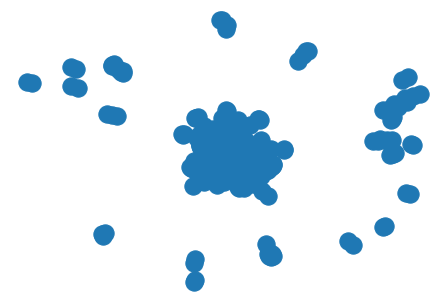

In [15]:
cor_graph
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

#cor_graph_pd (convert to pandas pd?)
#Gp=nx.from_pandas_edgelist(cor_graph_pd, source='text_y', target='text_x', edge_attr=True, create_using = nx.MultiDiGraph)

#draw graph 
nx.draw(cor_graph, with_labels=False)
plt.draw()

#### Explore Nodes
Count number of nodes in the networks

In [ ]:
# Explore entities 
# get the set of all entities appearing in a node
pybel_entities=pybel.struct.summary.node_summary.iterate_entities(pybel_graph)
#type(pybel_entities) # generator
#x=pybel_tools.summary.node_properties.Iterable()


In [ ]:
# explore entities

entities_list=[]
for entity in pybel_entities:
    entities_list.append(entity)

# intilize a null list 
unique_ent_list = [] 

# traverse for all elements 
for x in entities_list: 
    # check if exists in unique_list or not 
    if x not in unique_ent_list: 
        unique_ent_list.append(x)


In [ ]:
len(unique_ent_list) # 2236 unique entities

In [ ]:
# explore entities
entities_list[0:5] 

In [ ]:
# Explore nodes that are incorporate in edges 
import logging
from pybel.dsl import BaseConcept

for u,v,data in pybel_graph.edges(data=True):
    print("\n start new edge \n")

    print(data)
    
    node_entities=pybel.struct.summary.node_summary.iterate_node_entities(u)
    
    print("Explore source node identifiers \n")
    if isinstance(u, BaseConcept):
        entity = u.entity
        print(entity)
        print(u.name)
        print(u.obo)
        print("\n")
        
    # Explore keys that are in each entity node in relation graph
    # We will want to extract this info into the knowledge graph
    print("Explore source node functionality \n")

    for key, val in u.items():
        print(key)
        print(val)
        print("\n")

    print("Explore target node identifers \n")
    if isinstance(v, BaseConcept):
        entity = v.entity
        print(entity)
        print(v.name)
        print(v.obo)
        print("\n")
    else:
        print("Not a base concept (?)")
        print(v)

      
    print("Explore target node functionality \n")
    for key, val in v.items():
        print(key)
        print(val)
        print("\n")

        
    #if 'evidence' in data.keys():
        #print("Explore evidence \n")
        #print(data['evidence'])
    
    if 'relation' in data.keys():
        print("Explore relation \n")
        print(data['relation'])
        print("\n")

        
    print("Explore modifiers functionality \n")
    if 'object' in data.keys():
        obj=data['object']
        for key, val in obj.items():
            if key != 'modifier':
                print('modifier')
                print(key)
                print(val)
                print("\n")
                
    print("\n")
        



In [ ]:
# Create list of relation types
relations_pybel=pybel.struct.summary.count_relations(pybel_graph)
relations=[]
for i in relations_pybel.keys():
    relations.append(i)

In [ ]:
relations # 15 relation types

In [ ]:
namespaces_pybel=pybel.struct.summary.count_namespaces(pybel_graph)
len(namespaces_pybel) # 17 unique namespaces
namespaces_pybel

In [ ]:
# this returns nothing
#naked_names=pybel.struct.summary.count_naked_names(pybel_graph)
#naked_names

#### Load pre-processed covid19 frauenhofer manual annotations

WE can load the pybel graph AFTER it has been processed by our NER pipeline 

In [ ]:
# set the correct path location
# edit path to where your version of the csv file is
pybel_pd=pd.read_csv('/home/lani_lichtenstein/covid19_frauenhofer_annotations_entities.csv',index_col=0)

In [ ]:
# Explore head 
pybel_pd.head(2)

### Step3 - Label CORD-19 data with snorkel for Weak Supervision
Create label functions here to label data heuristically

Can also look at distant supervision - that is using a knowledge base (e.g. covid19kg) to label new unseen examples in the corpus.

In [ ]:
import snorkel

In [ ]:
# Define labeling function.. 
# This is an EXAMPLE of what a labelling function might look like
from snorkel.labeling import labeling_function

@labeling_function()
def lf_keyword_my(x):
    """Many spam comments talk about 'my channel', 'my video', etc."""
    return SPAM if "my" in x.text.lower() else ABSTAIN

### Step 4 - Train a Classifer with openNRE


For training
- need to have train,test, validate data (see examples in openNRE/pretrain/wiki80 for format)
- need to use a LM for encoding e.g. BERT of glove 
- need to select model (e.g. CNN)

See example of model training at:

https://github.com/thunlp/OpenNRE/blob/master/example/train_wiki80_bert_softmax.py 

To do:

(1) Get pybel dataset into format of openNRE training dataset (use wiki_train.txt as an example)

(2) Decide which model (e.g. CNN) and sentence embedding LM (e.g. BERT) we will use to train the openNRE classifier. 


Note - start with simple model e.g. CNN, later, we can  try Few Shot Classifier with Meta-Learner, to deal with small amount of labelled data.

https://www.aclweb.org/anthology/D18-1514.pdf

https://github.com/ProKil/FewRel/blob/master/train_demo.py

In [ ]:
import opennre

In [ ]:
# Example - check example works
model = opennre.get_model('wiki80_cnn_softmax')
model.infer({'text': 'He was the son of Máel Dúin mac Máele Fithrich, and grandson of the high king Áed Uaridnach (died 612).', 'h': {'pos': (18, 46)}, 't': {'pos': (78, 91)}})

In [ ]:
# Exploration of OpenNRE
# Explore wiki80 training data (to get an idea of training data format)
# Load the file, editing the path to the wiki data
path='/home/<USERNAME>/.opennre/benchmark/wiki80/wiki80_train.txt'
f = open(path)
data = []
for line in f.readlines():
    line = line.rstrip()
    if len(line) > 0:
        data.append(eval(line))
      

In [ ]:
with open('/home/<USERNAME>/.opennre/benchmark/wiki80/wiki80_rel2id.json') as f:
    rel2id = json.load(f)


In [ ]:
# explore data
# identify keys in the dictionary required for OpenNRE training data set 
type(data[0]) # data is a list of dicts 
keys=[]
for key in data[0].keys():
    keys.append(key)

print(keys)

In [ ]:
# Explore data
for value in data[0].values():
    print(type(value))

# token is a list of tokens
# h,t is a dict, with keys name,id, pos
# relation is a str

In [ ]:
# Explore wiki_train_data as training_data
wiki_data=pd.DataFrame(data)
wiki_data.columns
wiki_data.shape
wiki_data.head()

In [ ]:
wiki_data['h'][2] # entitys have a name, and an id

In [ ]:
#for key,val in rel2id.items():
#    print(key)
#    print(val)

#### Convert pybel dataframe of relations to correct training data format for OpenNRE

In [ ]:
pybel_pd.shape # 5236 training points
pybel_pd.head() # sentence, source, target, relation

In [ ]:
# sentence and source
pybel_pd['sentence'][1]
pybel_pd['source'][1]

In [ ]:
#!pip install spacy
#!python3 -m spacy download en_core_web_sm # consider scispacy
# use spacy to process sentence in pybel_pd - to tokenize sentence and get details such as source/target name, and position in text 

import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
## NEEDS TO BE COMPLETED ONCE ENTITY  GROUNDING IS COMPLETED 

# keys are token, h, t, relation
# token is a list of str tokens (spacy sep?)
# h, t are both dicts with elements keys name,id, pos
# relation is a str of type "relation"

pairs=[]
#for i in range(len(pybel_pd)):
for i in range(3):

    row=pybel_pd.iloc[i]
    sentence=row['sentence']
    sentence_spacy=nlp(sentence)
    token_value=[tok.text for tok in sentence_spacy]
    for token in sentence_spacy:
        print(token.text, token.idx)
        
    pairs.append(token_value) # first element in pairs list
    
    # now get head
    # seem to be in 'chebi' namespace
    head_value_dict=row['source']
    print(head_value_dict)
    
    #json_acceptable_string = head_value_dict.replace("'", "\" ")
    #print(json_acceptable_string)
    #d = json.loads(json_acceptable_string) # json not working 
    
    d = yaml.load(head_value_dict,Loader=yaml.FullLoader)
    for value_dict in d.values():
        head_namespace=value_dict['namespace']
        head_name=value_dict['name']
        head_identifier=dict['identifier']
     
    keys_head_dict= ['name', 'id', 'pos']
    #vals_head_dict=[head_name_value, head_identifier, ]

    #print(head_value_dict)
    #print(d)
    #
    head_value_dict['namespace']
    #dlist = [{k: v} for k, v in zip(keys, pairs)]
    

In [ ]:
# how to get tok.text if it matches sentence id.. 
print(head_name)
sentence_spacy
for tok in sentence_spacy:
    print(tok.text)
    print(head_name)
    if tok.text == head_name:
        a = tok.idx 

print(a)

### Example of OpenNRE model training
Our code will look something like this with the frameowork, model and training data customised. 

In [ ]:

#https://github.com/thunlp/OpenNRE/blob/master/example/train_nyt10_pcnn_att.py
    
import sys, json, 
import torch
import os
import numpy as np
import opennre
from opennre import encoder, model, framework
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--bag_size', type=int, default=0)
args = parser.parse_args()

# Some basic settings
root_path = '.'
if not os.path.exists('ckpt'):
    os.mkdir('ckpt')
ckpt = 'ckpt/nyt10_pcnn_att.pth.tar'

# Check data
opennre.download('nyt10', root_path=root_path)
opennre.download('glove', root_path=root_path)
rel2id = json.load(open(os.path.join(root_path, 'benchmark/nyt10/nyt10_rel2id.json')))
wordi2d = json.load(open(os.path.join(root_path, 'pretrain/glove/glove.6B.50d_word2id.json')))
word2vec = np.load(os.path.join(root_path, 'pretrain/glove/glove.6B.50d_mat.npy'))

# Define the sentence encoder
sentence_encoder = opennre.encoder.PCNNEncoder(
    token2id=wordi2d,
    max_length=120,
    word_size=50,
    position_size=5,
    hidden_size=230,
    blank_padding=True,
    kernel_size=3,
    padding_size=1,
    word2vec=word2vec,
    dropout=0.5
)

# Define the model
model = opennre.model.BagAttention(sentence_encoder, len(rel2id), rel2id)

# Define the whole training framework
framework = opennre.framework.BagRE(
    train_path='benchmark/nyt10/nyt10_train.txt',
    val_path='benchmark/nyt10/nyt10_val.txt',
    test_path='benchmark/nyt10/nyt10_test.txt',
    model=model,
    ckpt=ckpt,
    batch_size=160,
    max_epoch=60,
    lr=0.5,
    weight_decay=0,
    opt='sgd',
    bag_size=args.bag_size)

# Train the model
framework.train_model()

# Test the model
framework.load_state_dict(torch.load(ckpt)['state_dict'])
result = framework.eval_model(framework.test_loader)

# Print the result
print('AUC on test set: {}'.format(result['auc']))

## sPert

This is an alternative frameowork and python package for RC to OpenNRE.


In [ ]:
# explore example training data
ade_path='/home/lani_lichtenstein/spert/data/datasets/ade/ade_split_0_test.json'

In [ ]:
from collections import OrderedDict

In [ ]:
ade_types = json.load(open(ade_path), object_pairs_hook=OrderedDict)  # entity + relation types
len(ade_types) # 427 elements

In [ ]:
#ade_types is a list
# these tell us what is required for the training data
for key in ade_types:
    print(key) # tokens, entities, relations, orig_id

In [ ]:
# Explore an example
for item in ade_types[10].items():
    print(item)

In [ ]:
ade_types[0]['entities'] # only two entitiy types, adverse-effect, drug (from )